In [1]:
import numpy as np
import matplotlib.pyplot as plt

3.2 Roeの近似リーマン解

図3.5のパラメータに近いもの（バルク速度なし）

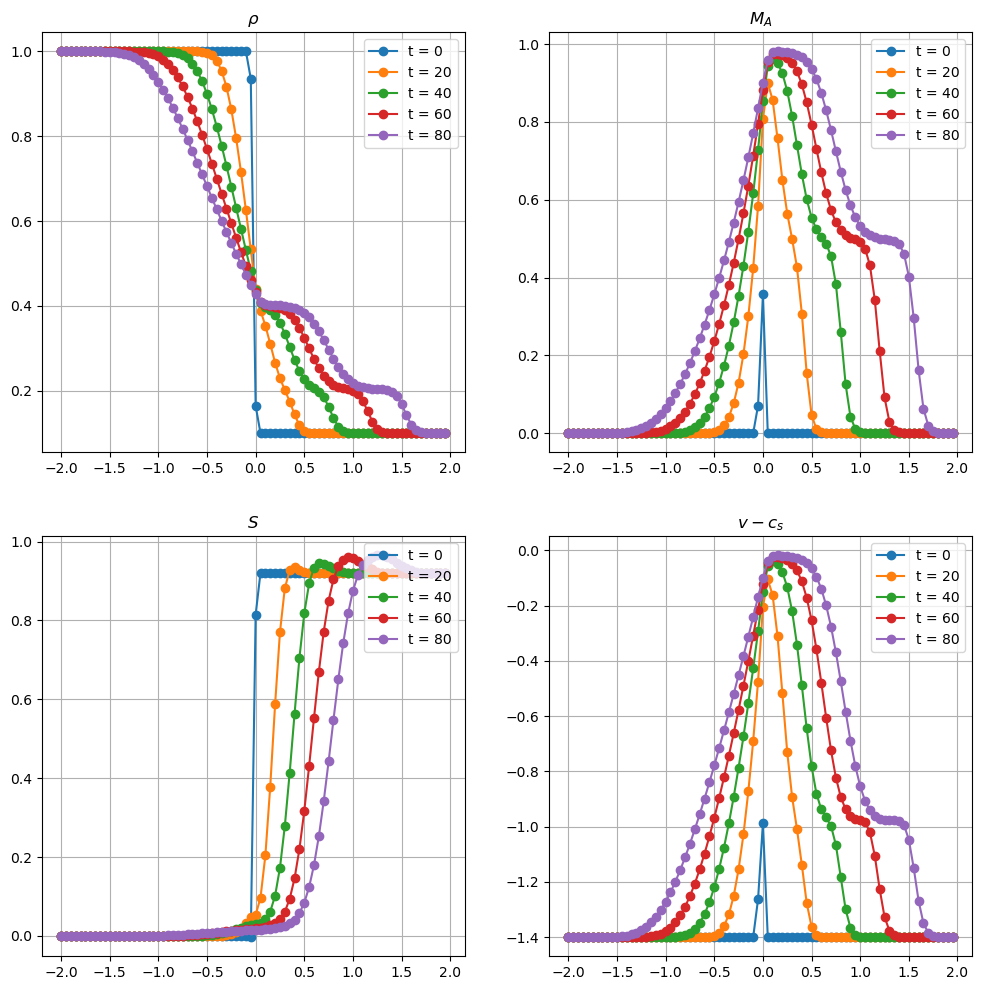

In [51]:
dx = 0.05
dt = 0.01
x = np.arange(-2, 2, dx)
nmax = len(x)

gamma = 1.4

rho_L = 1.0
p_L = 1.0
v_L = 0.0
rho_R = 0.1
p_R = 0.1
v_R = 0.0

U = np.zeros([x.shape[0], 3]) #rho, rho * v, rho * E 
U[x < 0, 0] = rho_L
U[x >= 0, 0] = rho_R
U[x < 0, 1] = rho_L * v_L
U[x >= 0, 1] = rho_R * v_R
U[x < 0, 2] = rho_L * (p_L/(rho_L*(gamma-1)) + v_L**2/2)
U[x >= 0, 2] = rho_R * (p_R/(rho_R*(gamma-1)) + v_R**2/2)

F = np.zeros([x.shape[0], 3])
F_roe = np.zeros([x.shape[0], 3])

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

step = 80
for t in range(step+1):
    rho = U[:, 0]
    v = U[:, 1] / rho 
    E = U[:, 2] / rho
    H = gamma * E - (gamma-1)/2 * v**2
    p = (H - E) * rho 
    
    rho_ave = np.sqrt(rho * np.roll(rho, -1))
    v_ave = (v * np.sqrt(rho) + np.roll(v, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    H_ave = (H * np.sqrt(rho) + np.roll(H, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    cs_ave = (gamma-1) * (H_ave - v_ave**2/2)

    lambda_1 = v_ave - cs_ave
    lambda_2 = v_ave 
    lambda_3 = v_ave + cs_ave
    r1 = np.array([np.ones(v_ave.shape[0]), v_ave - cs_ave, H_ave - v_ave*cs_ave]).T 
    r2 = np.array([np.ones(v_ave.shape[0]), v_ave, v_ave**2/2]).T
    r3 = np.array([np.ones(v_ave.shape[0]), v_ave + cs_ave, H_ave + v_ave*cs_ave]).T

    delta_rho = np.roll(rho, -1) - rho 
    delta_v = np.roll(v, -1) - v 
    delta_p = np.roll(p, -1) - p 
    delta_w = np.array([rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave - delta_v), 
                        delta_rho - delta_p/cs_ave**2, 
                        rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave + delta_v)
                        ])
    F[:, 0] = rho * v 
    F[:, 1] = rho * v**2 + p 
    F[:, 2] = rho * H * v 

    #どうにかまとめてできるはずだけど、とりあえずパスで
    F_roe[:, 0] = 1/2 * (F[:, 0] + np.roll(F[:, 0], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 0]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 0]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 0])
    F_roe[:, 1] = 1/2 * (F[:, 1] + np.roll(F[:, 1], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 1]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 1]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 1])
    F_roe[:, 2] = 1/2 * (F[:, 2] + np.roll(F[:, 2], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 2]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 2]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 2])
    
    U += -dt/dx * (F_roe - np.roll(F_roe, 1, axis=0))

    #対称境界条件にした
    U[0, :] = U[1, :]
    U[-1, :] = U[-2, :]
 
    #出力
    if t % 20 == 0:
        rho = U[:, 0]
        v = U[:, 1] / rho 
        E = U[:, 2] / rho
        H = gamma * E - (gamma-1)/2 * v**2
        p = (H - E) * rho 
        cs = (gamma-1) * (H - v**2/2)
        M_A = v / cs
        entropy = np.log(p / rho**gamma)

        ax1.plot(x, rho, marker='o', label=f't = {t}')
        ax2.plot(x, M_A, marker='o', label=f't = {t}')
        ax3.plot(x, entropy, marker='o', label=f't = {t}')
        ax4.plot(x, v - cs, marker='o', label=f't = {t}')

ax1.set_title(r"$\rho$")
ax2.set_title(r"$M_A$")
ax3.set_title(r"$S$")
ax4.set_title(r"$v - c_s$")
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
plt.show()

図3.5のパラメータで（バルク速度あり）

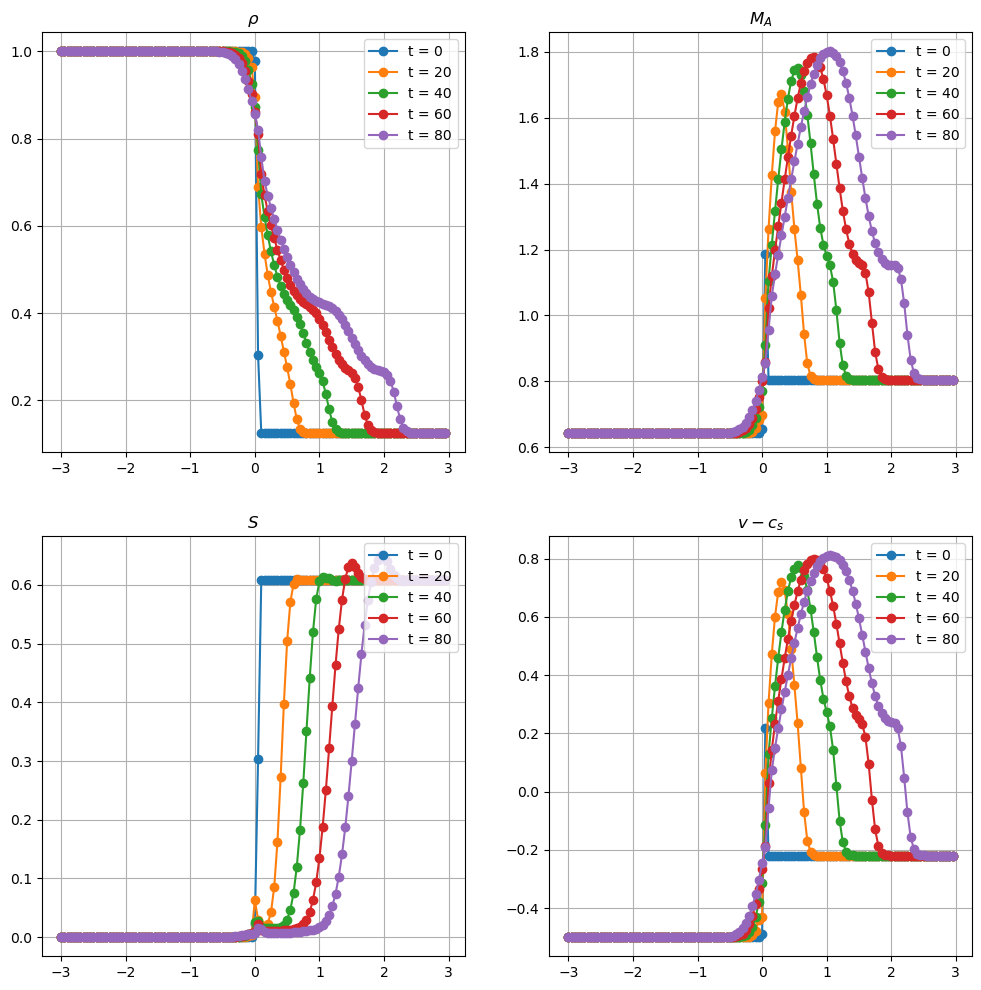

In [6]:
dx = 0.05
dt = 0.01
x = np.arange(-3, 3, dx)
nmax = len(x)

gamma = 1.4

rho_L = 1.0
p_L = 1.0
v_L = 0.9
rho_R = 0.125
p_R = 0.1
v_R = 0.9

U = np.zeros([x.shape[0], 3]) #rho, rho * v, rho * E 
U[x < 0, 0] = rho_L
U[x >= 0, 0] = rho_R
U[x < 0, 1] = rho_L * v_L
U[x >= 0, 1] = rho_R * v_R
U[x < 0, 2] = rho_L * (p_L/(rho_L*(gamma-1)) + v_L**2/2)
U[x >= 0, 2] = rho_R * (p_R/(rho_R*(gamma-1)) + v_R**2/2)

F = np.zeros([x.shape[0], 3])
F_roe = np.zeros([x.shape[0], 3])

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

step = 80
for t in range(step+1):
    rho = U[:, 0]
    v = U[:, 1] / rho 
    E = U[:, 2] / rho
    H = gamma * E - (gamma-1)/2 * v**2
    p = (H - E) * rho 
    
    rho_ave = np.sqrt(rho * np.roll(rho, -1))
    v_ave = (v * np.sqrt(rho) + np.roll(v, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    H_ave = (H * np.sqrt(rho) + np.roll(H, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    cs_ave = (gamma-1) * (H_ave - v_ave**2/2)

    lambda_1 = v_ave - cs_ave
    lambda_2 = v_ave 
    lambda_3 = v_ave + cs_ave
    r1 = np.array([np.ones(v_ave.shape[0]), v_ave - cs_ave, H_ave - v_ave*cs_ave]).T 
    r2 = np.array([np.ones(v_ave.shape[0]), v_ave, v_ave**2/2]).T
    r3 = np.array([np.ones(v_ave.shape[0]), v_ave + cs_ave, H_ave + v_ave*cs_ave]).T

    delta_rho = np.roll(rho, -1) - rho 
    delta_v = np.roll(v, -1) - v 
    delta_p = np.roll(p, -1) - p 
    delta_w = np.array([rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave - delta_v), 
                        delta_rho - delta_p/cs_ave**2, 
                        rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave + delta_v)
                        ])
    F[:, 0] = rho * v 
    F[:, 1] = rho * v**2 + p 
    F[:, 2] = rho * H * v 

    #どうにかまとめてできるはずだけど、とりあえずパスで
    F_roe[:, 0] = 1/2 * (F[:, 0] + np.roll(F[:, 0], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 0]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 0]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 0])
    F_roe[:, 1] = 1/2 * (F[:, 1] + np.roll(F[:, 1], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 1]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 1]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 1])
    F_roe[:, 2] = 1/2 * (F[:, 2] + np.roll(F[:, 2], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 2]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 2]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 2])
    
    U += -dt/dx * (F_roe - np.roll(F_roe, 1, axis=0))

    #対称境界条件にした
    U[0, :] = U[1, :]
    U[-1, :] = U[-2, :]
 
    #出力
    if t % 20 == 0:
        rho = U[:, 0]
        v = U[:, 1] / rho 
        E = U[:, 2] / rho
        H = gamma * E - (gamma-1)/2 * v**2
        p = (H - E) * rho 
        cs = (gamma-1) * (H - v**2/2)
        M_A = v / cs
        entropy = np.log(p / rho**gamma)

        ax1.plot(x, rho, marker='o', label=f't = {t}')
        ax2.plot(x, M_A, marker='o', label=f't = {t}')
        ax3.plot(x, entropy, marker='o', label=f't = {t}')
        ax4.plot(x, v - cs, marker='o', label=f't = {t}')

ax1.set_title(r"$\rho$")
ax2.set_title(r"$M_A$")
ax3.set_title(r"$S$")
ax4.set_title(r"$v - c_s$")
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
plt.show()

エントロピー補正

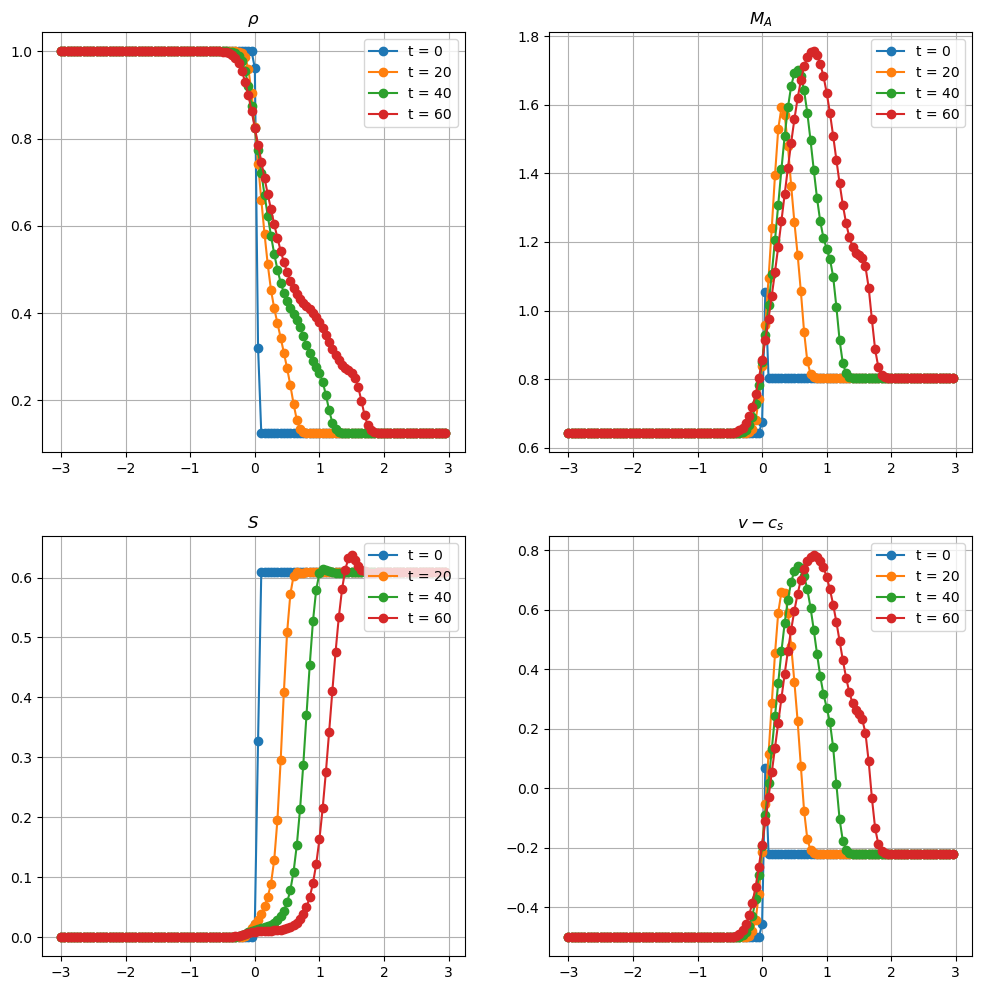

In [29]:
dx = 0.05
dt = 0.01
x = np.arange(-3, 3, dx)
nmax = len(x)

gamma = 1.4

rho_L = 1.0
p_L = 1.0
v_L = 0.9
rho_R = 0.125
p_R = 0.1
v_R = 0.9

U = np.zeros([x.shape[0], 3]) #rho, rho * v, rho * E 
U[x < 0, 0] = rho_L
U[x >= 0, 0] = rho_R
U[x < 0, 1] = rho_L * v_L
U[x >= 0, 1] = rho_R * v_R
U[x < 0, 2] = rho_L * (p_L/(rho_L*(gamma-1)) + v_L**2/2)
U[x >= 0, 2] = rho_R * (p_R/(rho_R*(gamma-1)) + v_R**2/2)

F = np.zeros([x.shape[0], 3])
F_roe = np.zeros([x.shape[0], 3])

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

step = 60
for t in range(step+1):
    rho = U[:, 0]
    v = U[:, 1] / rho 
    E = U[:, 2] / rho
    H = gamma * E - (gamma-1)/2 * v**2
    p = (H - E) * rho 
    cs = (gamma-1) * (H - v**2/2)
    
    rho_ave = np.sqrt(rho * np.roll(rho, -1))
    v_ave = (v * np.sqrt(rho) + np.roll(v, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    H_ave = (H * np.sqrt(rho) + np.roll(H, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    cs_ave = (gamma-1) * (H_ave - v_ave**2/2)

    lambda_1 = v_ave - cs_ave
    lambda_2 = v_ave
    lambda_3 = v_ave + cs_ave
    #エントロピー補正。ループで作ってしまうことにする。
    for i in range(nmax-1):
        lambda_1_left = v[i] - cs[i]
        lambda_1_right = v[i+1] - cs[i+1]
        epsilon = 10 * np.max([0, lambda_1[i] - lambda_1_left, lambda_1_right - lambda_1[i]])
        if (abs(lambda_1[i]) >= epsilon):
            lambda_1[i] = abs(lambda_1[i])
        else:
            lambda_1[i] = 1/2 * (lambda_1[i]**2/epsilon + epsilon)
        
        lambda_2_left = v[i]
        lambda_2_right = v[i+1]
        epsilon = 10 * np.max([0, lambda_2[i] - lambda_2_left, lambda_2_right - lambda_2[i]])
        if (abs(lambda_2[i]) >= epsilon):
            lambda_2[i] = abs(lambda_2[i])
        else:
            lambda_2[i] = 1/2 * (lambda_2[i]**2/epsilon + epsilon)
        
        lambda_3_left = v[i] + cs[i]
        lambda_3_right = v[i+1] + cs[i+1]
        epsilon = 10 * np.max([0, lambda_3[i] - lambda_3_left, lambda_3_right - lambda_3[i]])
        if (abs(lambda_3[i]) >= epsilon):
            lambda_3[i] = abs(lambda_3[i])
        else:
            lambda_3[i] = 1/2 * (lambda_3[i]**2/epsilon + epsilon)
    lambda_1[-1] = abs(lambda_1[-1])
    lambda_2[-1] = abs(lambda_2[-1])
    lambda_3[-1] = abs(lambda_3[-1])

    r1 = np.array([np.ones(v_ave.shape[0]), v_ave - cs_ave, H_ave - v_ave*cs_ave]).T 
    r2 = np.array([np.ones(v_ave.shape[0]), v_ave, v_ave**2/2]).T
    r3 = np.array([np.ones(v_ave.shape[0]), v_ave + cs_ave, H_ave + v_ave*cs_ave]).T

    delta_rho = np.roll(rho, -1) - rho 
    delta_v = np.roll(v, -1) - v 
    delta_p = np.roll(p, -1) - p 
    delta_w = np.array([rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave - delta_v), 
                        delta_rho - delta_p/cs_ave**2, 
                        rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave + delta_v)
                        ])
    F[:, 0] = rho * v 
    F[:, 1] = rho * v**2 + p 
    F[:, 2] = rho * H * v 

    #どうにかまとめてできるはずだけど、とりあえずパスで
    F_roe[:, 0] = 1/2 * (F[:, 0] + np.roll(F[:, 0], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 0]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 0]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 0])
    F_roe[:, 1] = 1/2 * (F[:, 1] + np.roll(F[:, 1], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 1]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 1]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 1])
    F_roe[:, 2] = 1/2 * (F[:, 2] + np.roll(F[:, 2], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 2]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 2]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 2])
    
    U += -dt/dx * (F_roe - np.roll(F_roe, 1, axis=0))

    #対称境界条件にした
    U[0, :] = U[1, :]
    U[-1, :] = U[-2, :]
 
    #出力
    if t % 20 == 0:
        rho = U[:, 0]
        v = U[:, 1] / rho 
        E = U[:, 2] / rho
        H = gamma * E - (gamma-1)/2 * v**2
        p = (H - E) * rho 
        cs = (gamma-1) * (H - v**2/2)
        M_A = v / cs
        entropy = np.log(p / rho**gamma)

        ax1.plot(x, rho, marker='o', label=f't = {t}')
        ax2.plot(x, M_A, marker='o', label=f't = {t}')
        ax3.plot(x, entropy, marker='o', label=f't = {t}')
        ax4.plot(x, v - cs, marker='o', label=f't = {t}')

ax1.set_title(r"$\rho$")
ax2.set_title(r"$M_A$")
ax3.set_title(r"$S$")
ax4.set_title(r"$v - c_s$")
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
plt.show()

3.3 空間精度の高次精度化

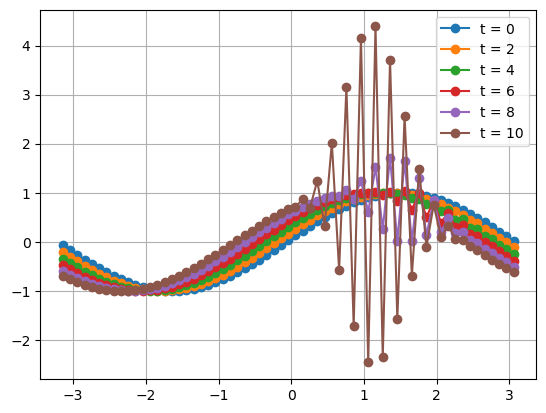

In [76]:
dx = 0.1
dt = 0.07
x = np.arange(-np.pi, np.pi, dx)
c = -1.0
kappa = -1.0

u = np.sin(x)

step = 10
for t in range(step+1):
    uL = u + (1-kappa)/4 * (u - np.roll(u, 1)) + (1+kappa)/4 * (np.roll(u, -1) - u)
    uR = np.roll(u, -1) - (1+kappa)/4 * (np.roll(u, -1) - u) - (1-kappa)/4 * (np.roll(u, -2) - np.roll(u, -1))
    F = 1/2 * c * (uL + uR) - abs(c)/2 * (uR - uL)
    u_bar = u - dt/dx * (F - np.roll(F, 1))
    uL_bar = u_bar + (1-kappa)/4 * (u_bar - np.roll(u_bar, 1)) + (1+kappa)/4 * (np.roll(u_bar, -1) - u_bar)
    uR_bar = np.roll(u_bar, -1) - (1+kappa)/4 * (np.roll(u_bar, -1) - u_bar) - (1-kappa)/4 * (np.roll(u_bar, -2) - np.roll(u_bar, -1))
    F_next = 1/2 * c * (uL_bar + uR_bar) - abs(c)/2 * (uR_bar - uL_bar)

    F = 1/2 * (F + F_next)
    u = u - dt/dx * (F - np.roll(F, 1))

    if t % 2 == 0:
        plt.plot(x, u, marker='o', label=f't = {t}')

plt.grid()
plt.legend(loc='upper right')
plt.show()

3.5 1次元問題の計算例

3.5.1 スカラー線形波動方程式

In [134]:
def minmod(x, y):
    return np.sign(x) * np.maximum(0, np.minimum(np.abs(x), np.sign(x)*y))


#これでいいはず。下の結果が角ばっているのはsuperbeeを使ったときの特徴らしいし
def superbee(x, y):
    return np.maximum(np.zeros(x.shape[0]), np.maximum(np.minimum(2*x, y), np.minimum(x, 2*y)))


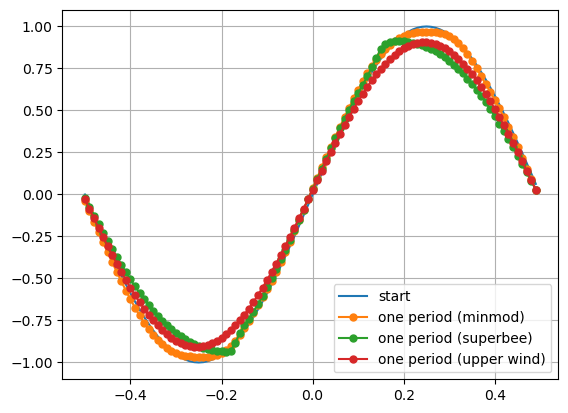

In [182]:
dx = 0.01
dt = 0.005
x = np.arange(-0.5, 0.5, dx)
c = -1.0

u = np.sin(2.0*np.pi*x)
plt.plot(x, u, label='start')

#minmod
step = int(1.0/dt)
for t in range(step+1):
    uL = u + 1/2 * minmod(np.roll(u, -1) - u, u - np.roll(u, 1))
    uR = np.roll(u, -1) - 1/2 * minmod(np.roll(u, -1) - u, np.roll(u, -2) - np.roll(u, -1))
    F = 1/2 * c * (uL + uR) - abs(c)/2 * (uR - uL)
    u_bar = u - dt/dx * (F - np.roll(F, 1))
    uL_bar = u_bar + 1/2 * minmod(np.roll(u_bar, -1) - u_bar, u_bar - np.roll(u_bar, 1))
    uR_bar = np.roll(u_bar, -1) - 1/2 * minmod(np.roll(u_bar, -1) - u_bar, np.roll(u_bar, -2) - np.roll(u_bar, -1))
    F_next = 1/2 * c * (uL_bar + uR_bar) - abs(c)/2 * (uR_bar - uL_bar)

    F = 1/2 * (F + F_next)
    u = u - dt/dx * (F - np.roll(F, 1))

u_minmod = u.copy()
plt.plot(x, u_minmod, marker='o', markersize=5, label=f'one period (minmod)')

#superbee
u = np.sin(2.0*np.pi*x)
step = int(1.0/dt)
for t in range(step+1):
    uL = u + 1/2 * superbee(np.roll(u, -1) - u, u - np.roll(u, 1))
    uR = np.roll(u, -1) - 1/2 * superbee(np.roll(u, -1) - u, np.roll(u, -2) - np.roll(u, -1))
    F = 1/2 * c * (uL + uR) - abs(c)/2 * (uR - uL)
    u_bar = u - dt/dx * (F - np.roll(F, 1))
    uL_bar = u_bar + 1/2 * superbee(np.roll(u_bar, -1) - u_bar, u_bar - np.roll(u_bar, 1))
    uR_bar = np.roll(u_bar, -1) - 1/2 * superbee(np.roll(u_bar, -1) - u_bar, np.roll(u_bar, -2) - np.roll(u_bar, -1))
    F_next = 1/2 * c * (uL_bar + uR_bar) - abs(c)/2 * (uR_bar - uL_bar)

    F = 1/2 * (F + F_next)
    u = u - dt/dx * (F - np.roll(F, 1))

u_superbee = u.copy()
plt.plot(x, u_superbee, marker='o', markersize=5, label=f'one period (superbee)')

#1次精度風上差分
u = np.sin(2.0*np.pi*x)
step = int(1.0/dt)
for t in range(step+1):
    F = 1/2 * (c * u + c * np.roll(u, -1)) - 1/2 * abs(c) * (np.roll(u, -1) - u)
    u += -dt/dx * (F - np.roll(F, 1))

u_upperwind = u.copy()
plt.plot(x, u_upperwind, marker='o', markersize=5, label=f'one period (upper wind)')

plt.grid()
plt.legend(loc='lower right')
plt.show()

In [186]:
c = 1.0
dx_list = np.array([0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1])
dt = 0.00005
results_error_L1 = []

for dx in dx_list:
    x = np.arange(-0.5, 0.5, dx)

    u = np.sin(2.0*np.pi*x)
    #minmod
    step = int(1.0/dt)
    for t in range(step+1):
        uL = u + 1/2 * minmod(np.roll(u, -1) - u, u - np.roll(u, 1))
        uR = np.roll(u, -1) - 1/2 * minmod(np.roll(u, -1) - u, np.roll(u, -2) - np.roll(u, -1))
        F = 1/2 * c * (uL + uR) - abs(c)/2 * (uR - uL)
        u_bar = u - dt/dx * (F - np.roll(F, 1))
        uL_bar = u_bar + 1/2 * minmod(np.roll(u_bar, -1) - u_bar, u_bar - np.roll(u_bar, 1))
        uR_bar = np.roll(u_bar, -1) - 1/2 * minmod(np.roll(u_bar, -1) - u_bar, np.roll(u_bar, -2) - np.roll(u_bar, -1))
        F_next = 1/2 * c * (uL_bar + uR_bar) - abs(c)/2 * (uR_bar - uL_bar)

        F = 1/2 * (F + F_next)
        u = u - dt/dx * (F - np.roll(F, 1))

    u_minmod = u.copy()

    #superbee
    u = np.sin(2.0*np.pi*x)
    step = int(1.0/dt)
    for t in range(step+1):
        uL = u + 1/2 * superbee(np.roll(u, -1) - u, u - np.roll(u, 1))
        uR = np.roll(u, -1) - 1/2 * superbee(np.roll(u, -1) - u, np.roll(u, -2) - np.roll(u, -1))
        F = 1/2 * c * (uL + uR) - abs(c)/2 * (uR - uL)
        u_bar = u - dt/dx * (F - np.roll(F, 1))
        uL_bar = u_bar + 1/2 * superbee(np.roll(u_bar, -1) - u_bar, u_bar - np.roll(u_bar, 1))
        uR_bar = np.roll(u_bar, -1) - 1/2 * superbee(np.roll(u_bar, -1) - u_bar, np.roll(u_bar, -2) - np.roll(u_bar, -1))
        F_next = 1/2 * c * (uL_bar + uR_bar) - abs(c)/2 * (uR_bar - uL_bar)

        F = 1/2 * (F + F_next)
        u = u - dt/dx * (F - np.roll(F, 1))

    u_superbee = u.copy()

    #1次精度風上差分
    u = np.sin(2.0*np.pi*x)
    step = int(1.0/dt)
    for t in range(step+1):
        F = 1/2 * (c * u + c * np.roll(u, -1)) - 1/2 * abs(c) * (np.roll(u, -1) - u)
        u += -dt/dx * (F - np.roll(F, 1))

    u_upperwind = u.copy()

    u_sol = np.sin(2.0*np.pi*x)
    results_error_L1.append([np.sum(np.abs(u_minmod - u_sol))/len(x), np.sum(np.abs(u_superbee - u_sol))/len(x), np.sum(np.abs(u_upperwind - u_sol))/len(x)])

合ってる？　なんか2次精度らしくないんだけど…

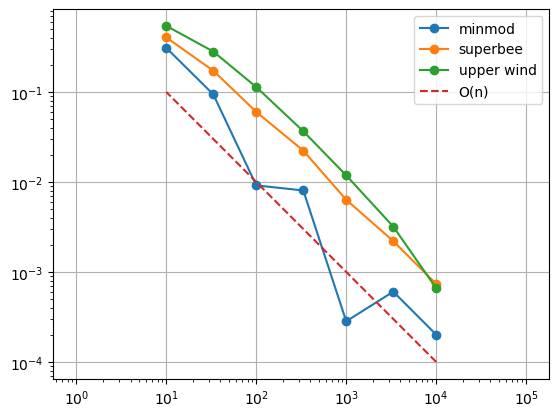

In [187]:
results_error_L1 = np.array(results_error_L1)

plt.plot(1.0/dx_list, results_error_L1[:, 0], marker='o', label='minmod')
plt.plot(1.0/dx_list, results_error_L1[:, 1], marker='o', label='superbee')
plt.plot(1.0/dx_list, results_error_L1[:, 2], marker='o', label='upper wind')
plt.plot(1.0/dx_list, (1.0/dx_list)**(-1), ls='--', label='O(n)')
plt.xscale('log')
plt.yscale('log')
plt.axis('equal')
plt.grid()
plt.legend(loc='upper right')
plt.show()

3.5.2 オイラー方程式

In [193]:
def get_roe_flux(U, F_L, F_R, F_roe):
    rho = U[:, 0]
    rho_L = rho + 1/2 * minmod(np.roll(rho, -1) - rho, rho - np.roll(rho, 1))
    rho_R = np.roll(rho, -1) - 1/2 * minmod(np.roll(rho, -1) - rho, np.roll(rho, -2) - np.roll(rho, -1))
    v = U[:, 1] / rho 
    v_L = v + 1/2 * minmod(np.roll(v, -1) - v, v - np.roll(v, 1))
    v_R = np.roll(v, -1) - 1/2 * minmod(np.roll(v, -1) - v, np.roll(v, -2) - np.roll(v, -1))
    E = U[:, 2] / rho
    E_L = E + 1/2 * minmod(np.roll(E, -1) - E, E - np.roll(E, 1))
    E_R = np.roll(E, -1) - 1/2 * minmod(np.roll(E, -1) - E, np.roll(E, -2) - np.roll(E, -1))
    H = gamma * E - (gamma-1)/2 * v**2
    H_L = gamma * E_L - (gamma-1)/2 * v_L**2
    H_R = gamma * E_R - (gamma-1)/2 * v_R**2
    p = (H - E) * rho
    p_L = (H_L - E_L) * rho_L 
    p_R = (H_R - E_R) * rho_R 
    
    rho_ave = np.sqrt(rho_L * rho_R)
    v_ave = (v_L * np.sqrt(rho_L) + v_R * np.sqrt(rho_R)) / (np.sqrt(rho_L) + np.sqrt(rho_R))
    H_ave = (H_L * np.sqrt(rho_L) + H_R * np.sqrt(rho_R)) / (np.sqrt(rho_L) + np.sqrt(rho_R))
    cs_ave = (gamma-1) * (H_ave - v_ave**2/2)

    lambda_1 = v_ave - cs_ave
    lambda_2 = v_ave 
    lambda_3 = v_ave + cs_ave
    r1 = np.array([np.ones(v_ave.shape[0]), v_ave - cs_ave, H_ave - v_ave*cs_ave]).T 
    r2 = np.array([np.ones(v_ave.shape[0]), v_ave, v_ave**2/2]).T
    r3 = np.array([np.ones(v_ave.shape[0]), v_ave + cs_ave, H_ave + v_ave*cs_ave]).T

    delta_rho = np.roll(rho, -1) - rho 
    delta_v = np.roll(v, -1) - v 
    delta_p = np.roll(p, -1) - p 
    delta_w = np.array([rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave - delta_v), 
                        delta_rho - delta_p/cs_ave**2, 
                        rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave + delta_v)
                        ])
    F_L[:, 0] = rho_L * v_L 
    F_L[:, 1] = rho_L * v_L**2 + p_L 
    F_L[:, 2] = rho_L * H_L * v_L 
    F_R[:, 0] = rho_R * v_R 
    F_R[:, 1] = rho_R * v_R**2 + p_R 
    F_R[:, 2] = rho_R * H_R * v_R 

    #どうにかまとめてできるはずだけど、とりあえずパスで
    F_roe[:, 0] = 1/2 * (F_L[:, 0] + F_R[:, 0]) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 0]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 0]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 0])
    F_roe[:, 1] = 1/2 * (F_L[:, 1] + F_R[:, 1]) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 1]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 1]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 1])
    F_roe[:, 2] = 1/2 * (F_L[:, 2] + F_R[:, 2]) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 2]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 2]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 2])
    
    return F_roe

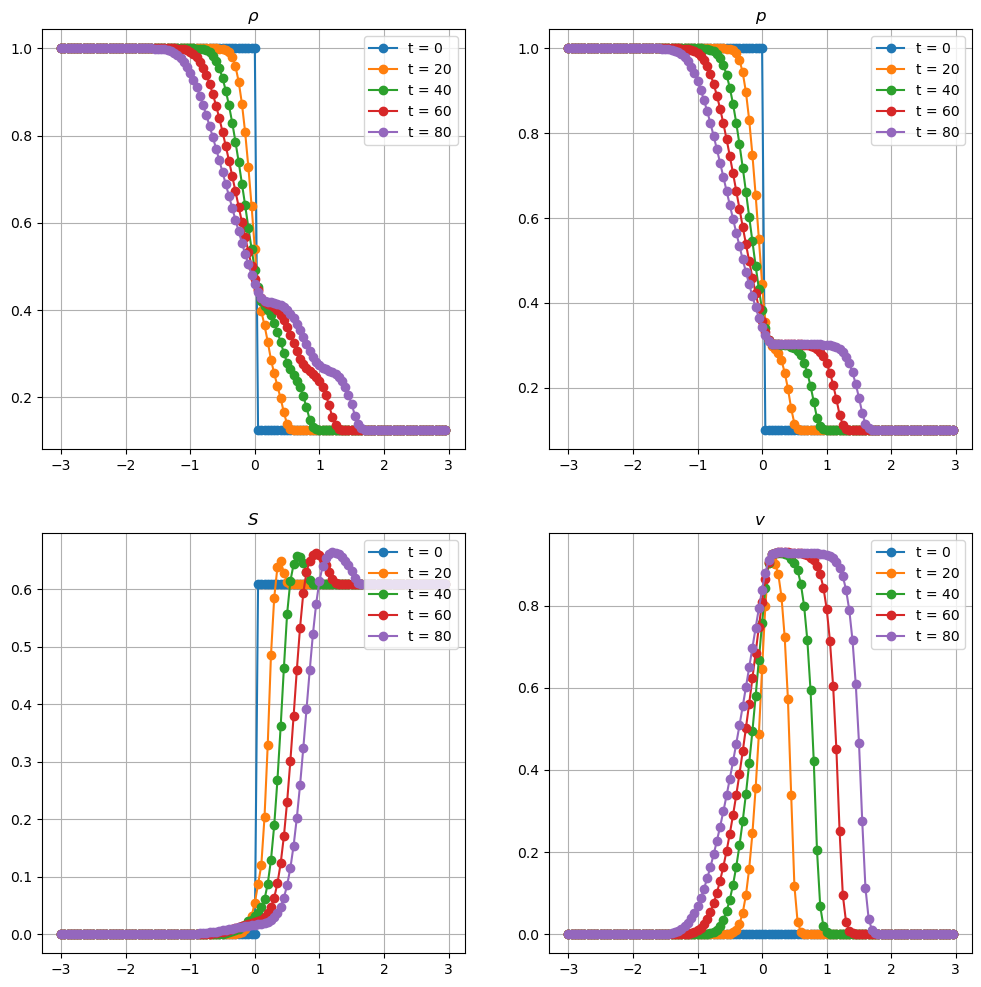

In [200]:
dx = 0.05
dt = 0.01
x = np.arange(-3, 3, dx)
nmax = len(x)

gamma = 1.4

rho_L_init = 1.0
p_L_init = 1.0
v_L_init = 0.0
rho_R_init = 0.125
p_R_init = 0.1
v_R_init = 0.0

U = np.zeros([x.shape[0], 3]) #rho, rho * v, rho * E 
U[x < 0, 0] = rho_L_init
U[x >= 0, 0] = rho_R_init
U[x < 0, 1] = rho_L_init * v_L_init
U[x >= 0, 1] = rho_R_init * v_R_init
U[x < 0, 2] = rho_L_init * (p_L_init/(rho_L_init*(gamma-1)) + v_L_init**2/2)
U[x >= 0, 2] = rho_R_init * (p_R_init/(rho_R_init*(gamma-1)) + v_R_init**2/2)

F_L = np.zeros([x.shape[0], 3])
F_R = np.zeros([x.shape[0], 3])
F_roe = np.zeros([x.shape[0], 3])
F_roe_next = np.zeros([x.shape[0], 3])
F = np.zeros([x.shape[0], 3])

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

step = 80
for t in range(step+1):

    #出力
    if t % 20 == 0:
        rho = U[:, 0]
        v = U[:, 1] / rho 
        E = U[:, 2] / rho
        H = gamma * E - (gamma-1)/2 * v**2
        p = (H - E) * rho 
        cs = (gamma-1) * (H - v**2/2)
        M_A = v / cs
        entropy = np.log(p / rho**gamma)

        ax1.plot(x, rho, marker='o', label=f't = {t}')
        ax2.plot(x, p, marker='o', label=f't = {t}')
        ax3.plot(x, entropy, marker='o', label=f't = {t}')
        ax4.plot(x, v, marker='o', label=f't = {t}')
    
    F_roe = get_roe_flux(U, F_L, F_R, F_roe)
    U_bar = U - dt/dx * (F_roe - np.roll(F_roe, 1, axis=0))
    #対称境界条件にした
    U_bar[0, :] = U_bar[1, :]
    U_bar[-1, :] = U_bar[-2, :]

    F_roe_next = get_roe_flux(U_bar, F_L, F_R, F_roe_next)
    F = 1/2 * (F_roe + F_roe_next)
    U = U - dt/dx * (F - np.roll(F, 1, axis=0))
    #対称境界条件にした
    U[0, :] = U[1, :]
    U[-1, :] = U[-2, :]
 

ax1.set_title(r"$\rho$")
ax2.set_title(r"$p$")
ax3.set_title(r"$S$")
ax4.set_title(r"$v$")
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
plt.show()

3.6 多次元化

2次元スカラー線形波動方程式

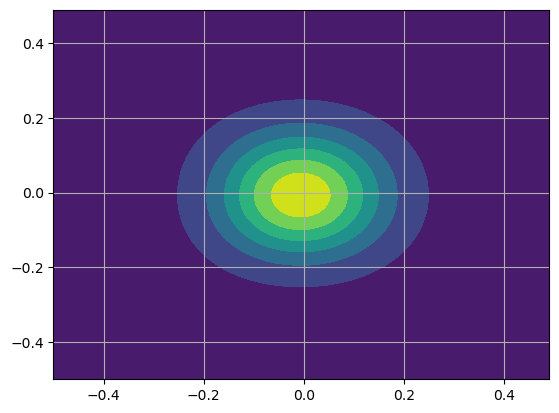

In [207]:
dx = 0.01
dy = 0.01
dt = 0.001
x = np.arange(-0.5, 0.5, dx)
y = np.arange(-0.5, 0.5, dy)
X, Y = np.meshgrid(x, y)
c = 1.0
d = 1.0

u = np.ones(X.shape)
u[(-0.1 < X) & (X < 0.1) & (-0.1 < Y) & (Y < 0.1)] = 2.0
F = np.zeros(u.shape)

#1次精度風上差分
step = int(1.0 / dt)
for t in range(step+1):
    F = 1/2 * c * (u + np.roll(u, -1, axis=1)) - 1/2 * abs(c) * (np.roll(u, -1, axis=1) - u)
    u += -dt/dx * (F - np.roll(F, 1, axis=1))
    F = 1/2 * d * (u + np.roll(u, -1, axis=0)) - 1/2 * abs(d) * (np.roll(u, -1, axis=0) - u)
    u += - dt/dy * (F - np.roll(F, 1, axis=0))

plt.contourf(X, Y, u)

plt.grid()
plt.show()

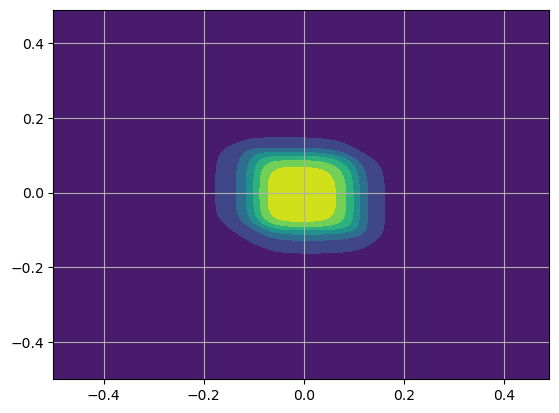

In [210]:
def minmod(x, y):
    return np.sign(x) * np.maximum(0, np.minimum(np.abs(x), np.sign(x)*y))


dx = 0.01
dy = 0.01
dt = 0.001
x = np.arange(-0.5, 0.5, dx)
y = np.arange(-0.5, 0.5, dy)
X, Y = np.meshgrid(x, y)
c = 1.0
d = 1.0

u = np.ones(X.shape)
u[(-0.1 < X) & (X < 0.1) & (-0.1 < Y) & (Y < 0.1)] = 2.0
F = np.zeros(u.shape)
F_next = np.zeros(u.shape)
uLx = np.zeros(u.shape)
uRx = np.zeros(u.shape)
uLy = np.zeros(u.shape)
uRy = np.zeros(u.shape)

#minmod
step = int(1.0/dt)
for t in range(step+1):
    u_bar = u.copy()
    uLx = u + 1/2 * minmod(np.roll(u, -1, axis=1) - u, u - np.roll(u, 1, axis=1))
    uRx = np.roll(u, -1, axis=1) - 1/2 * minmod(np.roll(u, -1, axis=1) - u, np.roll(u, -2, axis=1) - np.roll(u, -1, axis=1))
    F_x = 1/2 * c * (uLx + uRx) - abs(c)/2 * (uRx - uLx)
    u_bar += -dt/dx * (F_x - np.roll(F_x, 1, axis=1))
    uLy = u + 1/2 * minmod(np.roll(u, -1, axis=0) - u, u - np.roll(u, 1, axis=0))
    uRy = np.roll(u, -1, axis=0) - 1/2 * minmod(np.roll(u, -1, axis=0) - u, np.roll(u, -2, axis=0) - np.roll(u, -1, axis=0))
    F_y = 1/2 * d * (uLy + uRy) - abs(d)/2 * (uRy - uLy)

    u_bar -dt/dx * (F_y - np.roll(F_y, 1, axis=0))

    uLx = u_bar + 1/2 * minmod(np.roll(u_bar, -1, axis=1) - u_bar, u_bar - np.roll(u_bar, 1, axis=1))
    uRx = np.roll(u_bar, -1, axis=1) - 1/2 * minmod(np.roll(u_bar, -1, axis=1) - u_bar, np.roll(u_bar, -2, axis=1) - np.roll(u_bar, -1, axis=1))
    F_next_x = 1/2 * c * (uLx + uRx) - abs(c)/2 * (uRx - uLx)
    uLy = u_bar + 1/2 * minmod(np.roll(u_bar, -1, axis=0) - u_bar, u_bar - np.roll(u_bar, 1, axis=0))
    uRy = np.roll(u_bar, -1, axis=0) - 1/2 * minmod(np.roll(u_bar, -1, axis=0) - u_bar, np.roll(u_bar, -2, axis=0) - np.roll(u_bar, -1, axis=0))
    F_next_y = 1/2 * d * (uLy + uRy) - abs(d)/2 * (uRy - uLy)

    F_x = 1/2 * (F_x + F_next_x)
    F_y = 1/2 * (F_y + F_next_y)
    u += - dt/dx * (F_x - np.roll(F_x, 1, axis=1)) - dt/dy * (F_y - np.roll(F_y, 1, axis=0))

plt.contourf(X, Y, u)

plt.grid()
plt.show()

2次元オイラー方程式